# Represented cellular functions within cluster

In [1]:
import pandas as pd
import numpy as np
import os
import json
import copy
from matplotlib import pyplot as plt
import Dokdonia_code as Dc
%matplotlib inline

Here, we are performing a permutation analysis to assess to which extent observed results could be explain by random effects. In a permutation test, we follow exactly the same procedures that we used to generate our results in the first place, but we permute or relabel the genes to create a random data set, repeating this process $N = 500000$ in our case (see below for a sensitivity analysis on N). 

Contrary to other methods, we are not performing hypothesis testing. Thus, the sample p-values obtained through the permutation analysis are employed merely as indicators of how significant or surprising are our results, in comparison to the ones we would get in a random process. For this reason, we do not employ any cutoff value to classify pathways as significant or no significant. Instead, we use sample p-values to rank pathways, from more significant (or less likely) to less significant (more likely attributed to randomness).

# Analysis of permutation sample size effect on p-value

In  the plot below, we see that p-values quickly stabilize as sample size increases. Thus establishing $N = 500000$ seems like a safe choice.

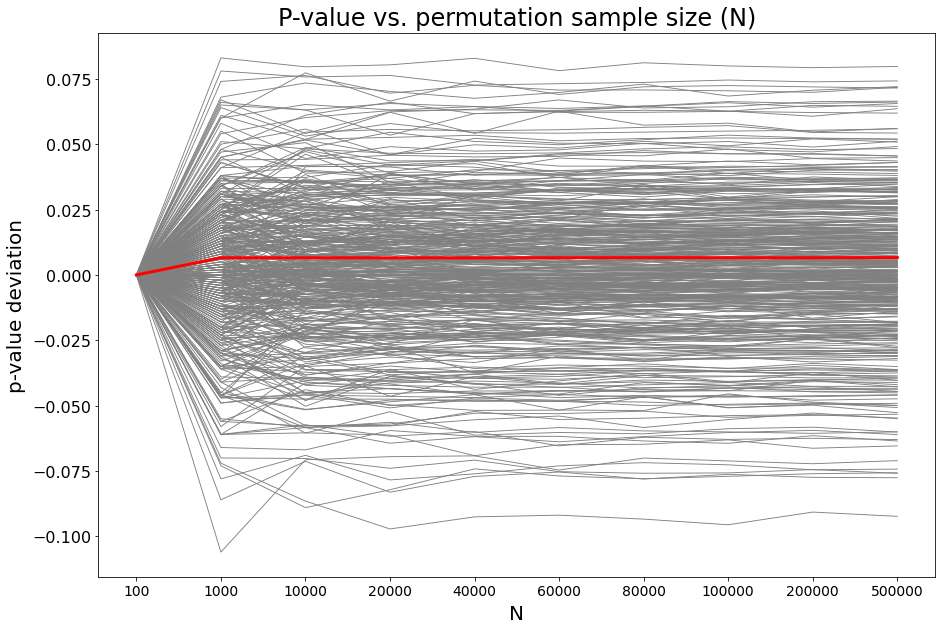

In [8]:
res = {}
pvalue_series = {'system': [], 'subsystem': []}
cluster_ids = [f'C{i}' for i in range(8)]
n_permutations = [100, 1000, 10000, 20000, 40000, 60000, 80000, 100000, 200000, 500000]

for N in n_permutations:
    res[N] = Dc.readFromPickleFile(path_to_file=f'Results/Permutation_analysis/KEGG/p_KEGG_paths_{N}.pkl')
    pvalue_series['system'].append([v[1] for c in cluster_ids for v in res[N][c]['system'].values()])
    pvalue_series['subsystem'].append([v[1] for c in cluster_ids for v in res[N][c]['subsystem'].values()])
    
# Plot results
pvalue_data = pd.DataFrame(
    np.concatenate((np.array(pvalue_series['system']), np.array(pvalue_series['subsystem'])), axis=1)
)
diff_pvalue_data = pvalue_data.sub(pvalue_data.iloc[0,:])
ax = diff_pvalue_data.plot(legend=False, figsize=(15,10), color='grey', 
                                                 linewidth=0.9, ylabel='p-value deviation', xlabel='N',
                                                 title='P-values vs. permutation sample size (N)')

diff_pvalue_data.abs().mean(axis=1).plot(color='red', ax=ax)
ax.set_xticks([i for i in range(len(n_permutations))])
l = ax.set_xticklabels(n_permutations, fontsize=14)

# Evaluating how transcripts/cell data normalization performs in comparison to TPM

Transcripts/cell is defined as:

$$transcripts_i.cell^{-1} = \frac{counts_i \hat{R_{st}}}{A_c} \;\; (1)$$

where,

$R_{{st}_j} = \frac{molecules_j}{counts_j}$

$A_c :=$ total cell abundance.

Some observations:

1. count data are not normalized by transcript length (assuming number of aligned reads independent of transcript length)
2. the above transformation adds new sources of experimental error in the quantities $R_{st}$ and $A_c$, both in a multiplicative manner.
3. are internal standards added before or after digestion of RNA? i.e., is the internal standard sequence also cut in pieces?
4. we could normalize results by length in (1).

In [2]:
# Loading counts and removing genes with low read counts across samples
min_count = 10

counts = pd.read_csv('Data/DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
counts.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,41014,22449,53840,32369,...,16255,23945,20102,39444,41721,37020,39662,30983,27280,57834
1,MED134_07384,1557,1555,1552,4160,4385,5588,2940,7550,4509,...,2564,3003,2894,5419,5536,5318,5396,4751,4285,7818
2,MED134_07379,3400,3319,3273,7218,7903,9539,5040,13268,7572,...,4575,5361,4923,9089,9016,8529,10179,7617,7207,13827
3,MED134_07374,1987,2124,1404,3509,3772,4337,2602,4607,3316,...,1798,2558,2637,3586,3594,3488,4158,3096,2623,5323
4,MED134_07369,2087,2010,2111,3774,3809,4486,2901,4668,3456,...,2545,3456,3008,3705,4158,3760,5518,3563,2713,5150


In [3]:
# Loading Internal Standard counts and removing genes with low read counts across samples
min_count = 10

IS_counts = pd.read_csv('Data/Laura_Normalization/SulfoStandardsCounts.csv', index_col=0)
IS_counts = IS_counts[IS_counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in IS_counts.columns]
IS_counts.columns = conditions
IS_counts = IS_counts[(IS_counts > min_count).all(1)]
IS_counts.reset_index(level=0, inplace=True)
IS_counts

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,s3_pdhD_v1_1000_Frag,72598,49476,44781,41976,45059,61529,43659,238,38833,...,44528,62015,83731,71613,70473,68516,57863,50533,45087,66020
1,s6_hyp1378_v1_964_Frag,72653,47522,60846,43220,43982,55793,50789,215,41727,...,53412,68243,88206,70797,66017,76033,58339,51977,55047,65414
2,s7_hyp1273_v1_991_Frag,52469,37019,55667,33402,37222,47338,38300,217,34221,...,49129,55926,84796,54971,49270,72528,46602,48531,45793,53807
3,s13_therm_v1_613_Frag,114019,71758,97845,66170,75550,98543,80188,368,68877,...,97668,110083,146095,112836,96878,126030,93214,85357,86459,104693
4,s14_virB_v1_301_Frag,76247,54063,90804,59967,72004,81346,64649,327,59965,...,66344,99487,137419,85065,82237,120758,88558,92649,86015,101281
5,s15_alpha_v1_1504_Frag,33805,23077,17434,20281,20625,37129,21961,152,20046,...,19517,25030,32513,37034,34845,30555,26086,21041,18819,42985


In [4]:
# Load and format standards data
standards_data = pd.read_excel('Data/Laura_Normalization/Standards_Dokdonia.xlsx', index_col=0)
standards_data.reset_index(level=0, inplace=True)
standards_data = standards_data[(standards_data['Standard'].notna()) & (standards_data['Sample ID'].notna())]
standards_data['Standard'] = standards_data['Standard'].apply(lambda s: s.strip())
standards_data['Sample ID'] = standards_data['Sample ID'].apply(lambda s: s.strip())
standards_data.head()

,Sample ID,Standard,Standard reads counts,Standard stock (pg/uL),Volume added (uL),Standard added (pg),Length (bp),MW (g/mol),Avogadro (molec/mol),moleculas/gr,Standard added (copias),Standard ratio,Avg Standard ratio,DesvS ratio,CV
0,L_10_R1,s13_therm_v1_613_Frag,201008.0,25.807806,20.0,516.15611,613.0,208420.0,6.022000e+23,2.889358e+18,1.491360e+09,7419.405196,8361.014907,3315.683084,39.656467
1,L_10_R1,s14_virB_v1_301_Frag,121484.0,14.993974,20.0,299.87948,301.0,102340.0,6.022000e+23,5.884307e+18,1.764583e+09,14525.229550,NaN,NaN,NaN
2,L_10_R1,s15_alpha_v1_1504_Frag,58100.0,14.230661,20.0,284.61321,1504.0,511360.0,6.022000e+23,1.177644e+18,3.351730e+08,5768.898780,NaN,NaN,NaN
3,L_10_R1,s3_pdhD_v1_1000_Frag,124049.0,22.149535,20.0,442.99070,1000.0,340000.0,6.022000e+23,1.771176e+18,7.846147e+08,6325.038529,NaN,NaN,NaN
4,L_10_R1,s6_hyp1378_v1_964_Frag,126235.0,22.246123,20.0,444.92246,964.0,327760.0,6.022000e+23,1.837320e+18,8.174649e+08,6475.739136,NaN,NaN,NaN


In [5]:
# load and format abundance data
abundance_meta = pd.read_excel('Data/Laura_Normalization/Abundancias_Dokdonia.xlsx', index_col=0)
abundance_meta.reset_index(level=0, inplace=True)
abundance_meta = abundance_meta[abundance_meta['Sample'].notna()]
abundance_meta['Sample'] = abundance_meta['Sample'].apply(lambda s: s.strip())
abundance_meta.head()

,Sample,Avg_Standard_ratio,Abundancia_cells_mL,Vol_filtered_mL,Total_cell_abundance
0,L_10_R1,8361.014907,1.521921e+06,500,7.609607e+08
1,L_10_R2,25169.662201,1.086850e+06,500,5.434251e+08
2,L_10_R3,21891.978025,1.219073e+06,500,6.095364e+08
3,D_10_R1,14032.230064,1.135166e+06,490,5.562311e+08
4,D_10_R2,20613.230047,1.170827e+06,500,5.854134e+08


In [23]:
# Compute Transcripts/Cell (Would check how replicate variance changed after transformation)
avg_st_ratios = Dc.getAverageStandardRatio(IS_counts, standards_data)
n_counts = Dc.getTranscriptsPerCell(counts, avg_st_ratios, abundance_meta)
n_counts.to_csv('Data/Dokdonia_transcripts_cell.csv')
n_counts.head()

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R2,D_25_R3,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,0.327274,0.402326,0.319319,1.504600,2.588597,1.816263,NaN,1.252534,1.377925,...,1.024204,0.600671,NaN,1.162753,1.091035,1.497091,0.894585,0.969526,1.271870,1.474154
1,MED134_07384,0.039279,0.054754,0.037400,0.204387,0.370730,0.247459,NaN,0.174478,0.189857,...,0.161554,0.075332,NaN,0.159744,0.144771,0.215060,0.121708,0.148669,0.199779,0.199276
2,MED134_07379,0.085773,0.116867,0.078872,0.354630,0.668159,0.422425,NaN,0.293002,0.369985,...,0.288264,0.134483,NaN,0.267931,0.235775,0.344913,0.229589,0.238353,0.336011,0.352442
3,MED134_07374,0.050127,0.074789,0.033833,0.172402,0.318904,0.192060,NaN,0.128314,0.152053,...,0.113289,0.064169,NaN,0.105710,0.093986,0.141055,0.093785,0.096881,0.122292,0.135680
4,MED134_07369,0.052649,0.070775,0.050870,0.185422,0.322032,0.198658,NaN,0.133732,0.137702,...,0.160357,0.086695,NaN,0.109218,0.108735,0.152055,0.124460,0.111494,0.126488,0.131270


In [27]:
ne_counts = pd.read_csv('Data/Dokdonia_transcripts_cell.csv', index_col=0)
ne_counts

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R2,D_25_R3,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,0.327274,0.402326,0.319319,1.504600,2.588597,1.816263,NaN,1.252534,1.377925,...,1.024204,0.600671,NaN,1.162753,1.091035,1.497091,0.894585,0.969526,1.271870,1.474154
1,MED134_07384,0.039279,0.054754,0.037400,0.204387,0.370730,0.247459,NaN,0.174478,0.189857,...,0.161554,0.075332,NaN,0.159744,0.144771,0.215060,0.121708,0.148669,0.199779,0.199276
2,MED134_07379,0.085773,0.116867,0.078872,0.354630,0.668159,0.422425,NaN,0.293002,0.369985,...,0.288264,0.134483,NaN,0.267931,0.235775,0.344913,0.229589,0.238353,0.336011,0.352442
3,MED134_07374,0.050127,0.074789,0.033833,0.172402,0.318904,0.192060,NaN,0.128314,0.152053,...,0.113289,0.064169,NaN,0.105710,0.093986,0.141055,0.093785,0.096881,0.122292,0.135680
4,MED134_07369,0.052649,0.070775,0.050870,0.185422,0.322032,0.198658,NaN,0.133732,0.137702,...,0.160357,0.086695,NaN,0.109218,0.108735,0.152055,0.124460,0.111494,0.126488,0.131270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,MED134_14782,0.039481,0.060423,0.038364,0.111823,0.204007,0.115271,NaN,0.071974,0.070502,...,0.093568,0.049293,NaN,0.056186,0.057453,0.079869,0.055553,0.051976,0.066717,0.074021
2873,MED134_14787,0.107292,0.158803,0.105982,0.303337,0.573046,0.332617,NaN,0.166700,0.201776,...,0.206227,0.112834,NaN,0.139787,0.125445,0.178826,0.112550,0.124199,0.183181,0.191884
2874,MED134_14792,0.142055,0.209121,0.105765,0.297933,0.604919,0.325354,NaN,0.176954,0.235515,...,0.165524,0.086946,NaN,0.169089,0.129315,0.186307,0.108220,0.105830,0.152969,0.172869
2875,MED134_14797,0.018870,0.031127,0.021640,0.051784,0.098072,0.061068,NaN,0.033665,0.042635,...,0.040578,0.020344,NaN,0.026265,0.023379,0.033323,0.037938,0.039459,0.055155,0.052355


In [24]:
# Scaling everything up to avoid very low numbers
n_counts.iloc[:,1:] = 1e4 * n_counts.iloc[:,1:]
n_counts.head()

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R2,D_25_R3,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,3272.742595,4023.255679,3193.191427,15046.001051,25885.970883,18162.634520,NaN,12525.337743,13779.248042,...,10242.042265,6006.706745,NaN,11627.525559,10910.352316,14970.913156,8945.846865,9695.256532,12718.703565,14741.535906
1,MED134_07384,392.789657,547.537422,373.996913,2043.866391,3707.295784,2474.589206,NaN,1744.778890,1898.573010,...,1615.539610,753.315530,NaN,1597.443490,1447.705242,2150.602814,1217.079060,1486.691533,1997.787565,1992.760793
2,MED134_07379,857.729502,1168.666690,788.719005,3546.304715,6681.586906,4224.249541,NaN,2930.021236,3699.854578,...,2882.641856,1344.830021,NaN,2679.306861,2357.751168,3449.133396,2295.894691,2383.525449,3360.106180,3524.418456
3,MED134_07374,501.267212,747.890343,338.332259,1724.020954,3189.035279,1920.596526,NaN,1283.141894,1520.526262,...,1132.894001,641.685356,NaN,1057.101376,939.857775,1410.549570,937.845577,968.805933,1222.916402,1356.800422
4,MED134_07369,526.494550,707.749336,508.703275,1854.219173,3220.316908,1986.579667,NaN,1337.315556,1377.021384,...,1603.567983,866.952537,NaN,1092.180869,1087.347977,1520.546555,1244.596415,1114.940420,1264.876934,1312.703771


# Obtain DE genes across temperatures with DeSeq2

In [8]:
# Do not discriminate between Light and Dark conditions
p_value_cutoff = 5e-2
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = Dc.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Cluster transcript/cell data with Clust (Quantile normalization + log2 + Z-scores transformation)

Using previously identified DE genes across temperature (DeSeq2)

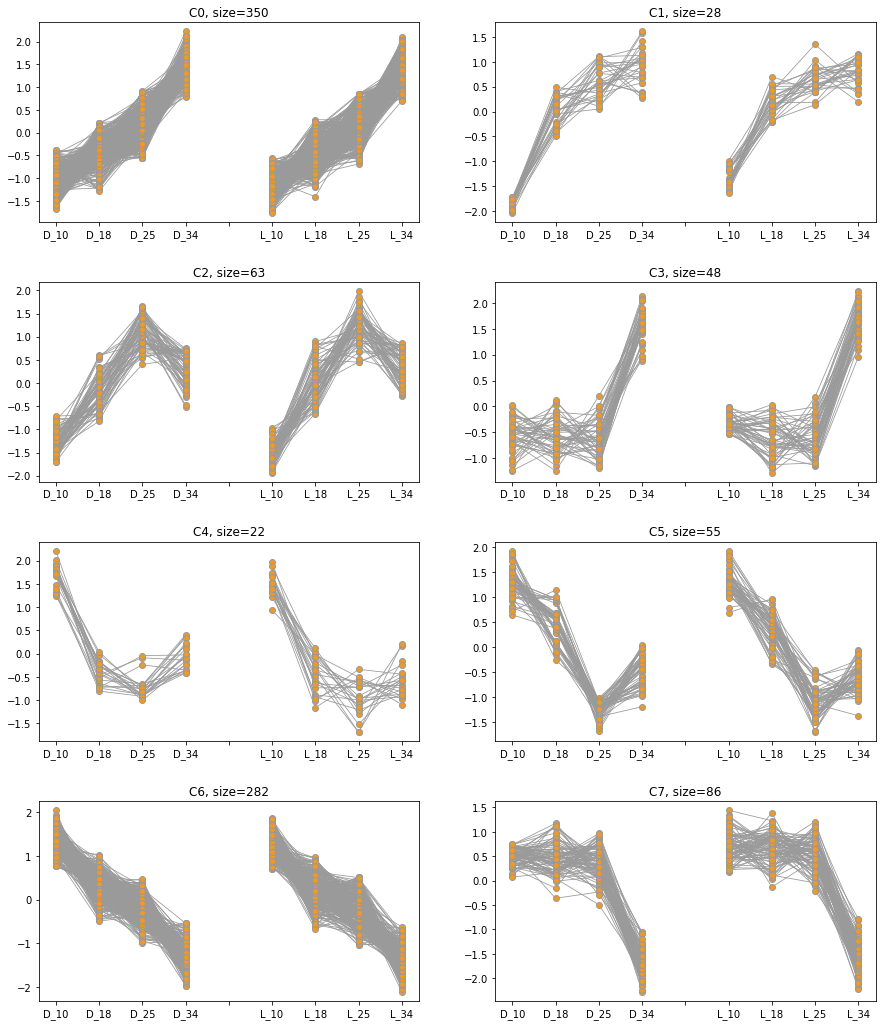

In [25]:
clust_data = n_counts
clust_data = clust_data[clust_data.filter(regex='^[^T]+$').columns]
clust_data= clust_data.set_index('index')
clust_data.index.name = 'ID'

# Cluster only DE genes across temperatures (n_counts)
res_id = 'CLUSTER_DE_GENES_TRANSCRIPT_CELL'
workdir = os.path.join(os.getcwd(),'Results')

gene_ids = T_res['all'].index
workdir = os.path.join(os.getcwd(),'Results')
DE_Data = clust_data[clust_data.index.isin(gene_ids)]

clusters = Dc.getGeneClusters(DE_Data, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=2,
                              normalization_file='clust_TPM_normalization.txt')

pdata = pd.read_csv(os.path.join(
    os.getcwd(),f'Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')
# Add fake column to separate datasets
pdata.insert(4, '', [np.nan for n in range(pdata.shape[0])])

Dc.plotClusters(pdata, clusters)

# Cluster transcript/cell data with Clust (Quantile normalization + log2 + Z-scores transformation)

Using ALL genes. Cluster tightness = 4 is the minimum value that maximizes the number of clusters. We can justify it because we are interested in increasing the resolution of the clusters. The new patterns are interesting (also ascending or descending but adding new features).

Also, considering using ALL genes in the clustering analysis. Clust was desgined to be used this way, and also, in this manner we avoid the issue of selecting gene set for the permutation analysis.

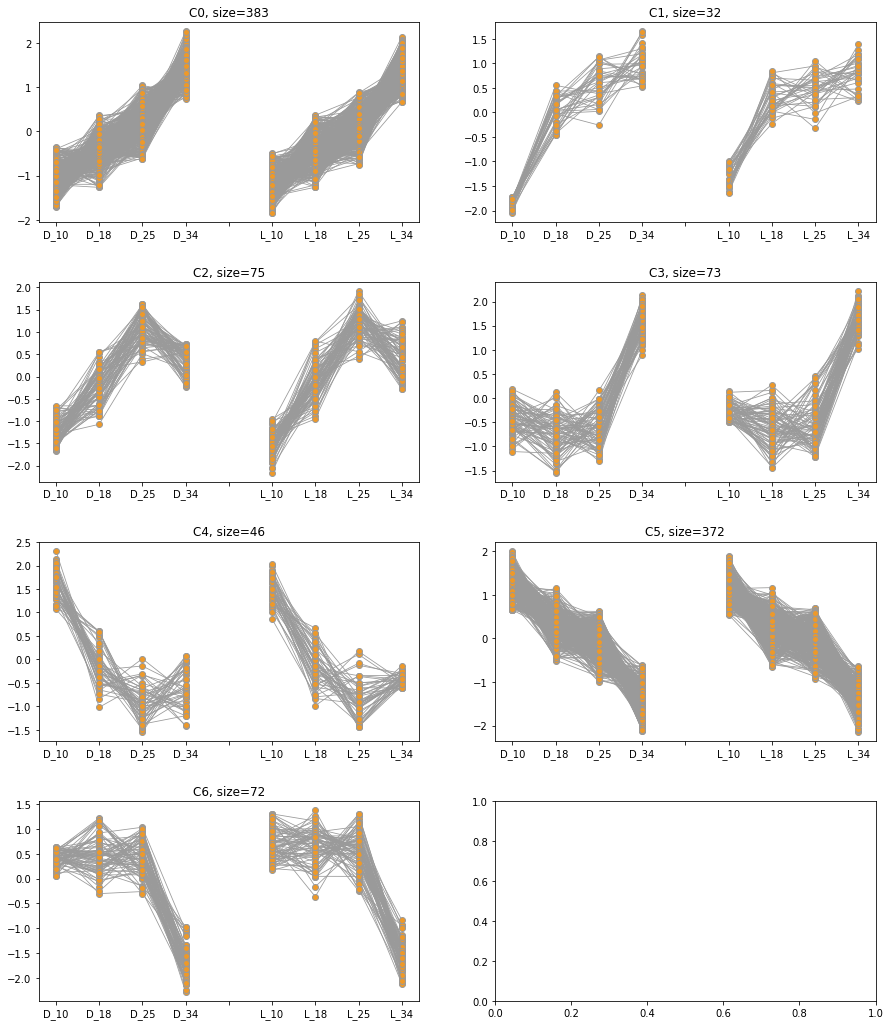

In [26]:
clust_data = n_counts
clust_data = clust_data[clust_data.filter(regex='^[^T]+$').columns]
clust_data= clust_data.set_index('index')
clust_data.index.name = 'ID'

# Cluster only DE genes across temperatures (n_counts)
res_id = 'CLUSTER_ALL_GENES_TRANSCRIPT_CELL'
workdir = os.path.join(os.getcwd(),'Results')

clusters = Dc.getGeneClusters(clust_data, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=4,
                              normalization_file='clust_TPM_normalization.txt')

pdata = pd.read_csv(os.path.join(
    os.getcwd(),f'Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')
# Add fake column to separate datasets
pdata.insert(4, '', [np.nan for n in range(pdata.shape[0])])

Dc.plotClusters(pdata, clusters)

# Clust with TPM values

All genes

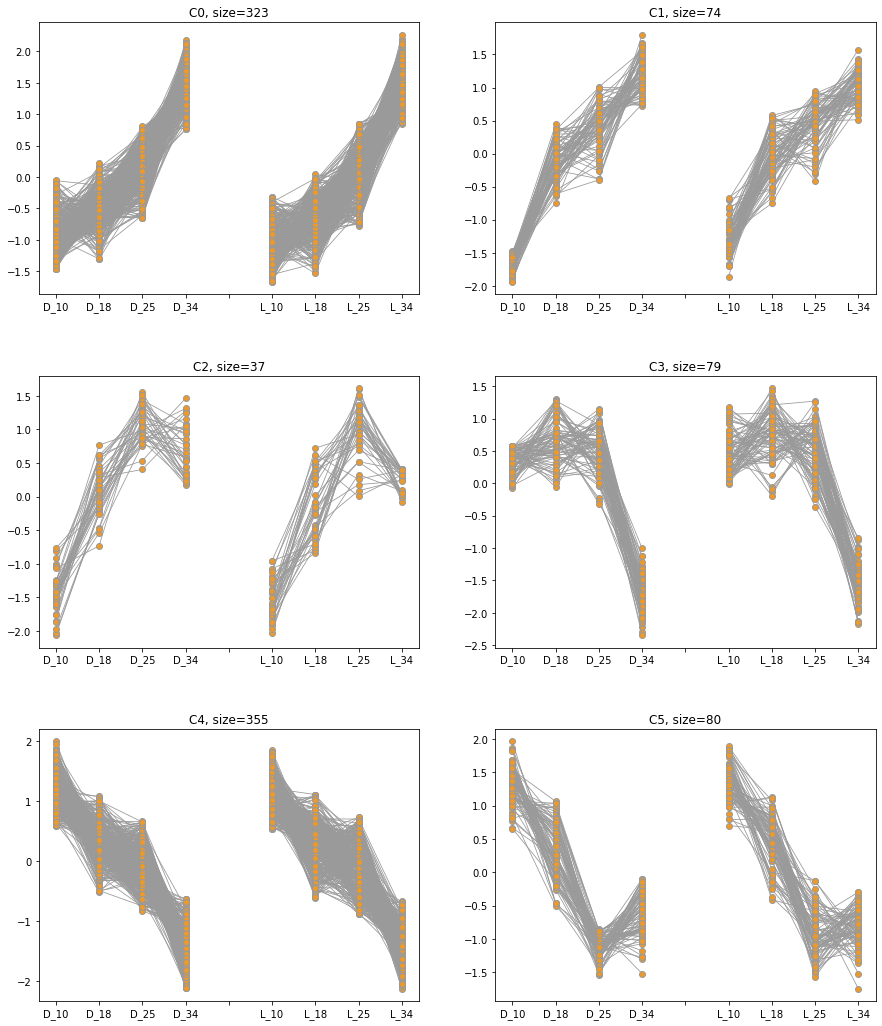

In [31]:
clust_data_TPM = pd.read_csv('Data/tpm_counts.csv', index_col=0)
clust_data_TPM = clust_data_TPM[clust_data_TPM.filter(regex='^[^T]+$').columns]
clust_data_TPM.index.name = 'ID'
clust_data_TPM.columns = conditions

# Cluster only DE genes across temperatures (n_counts)
res_id = 'CLUSTER_ALL_GENES_TPM'
workdir = os.path.join(os.getcwd(),'Results')

clusters = Dc.getGeneClusters(clust_data_TPM, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=5,
                              normalization_file='clust_TPM_normalization.txt')

pdata = pd.read_csv(os.path.join(
    os.getcwd(),f'Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')
# Add fake column to separate datasets
pdata.insert(4, '', [np.nan for n in range(pdata.shape[0])])

Dc.plotClusters(pdata, clusters)